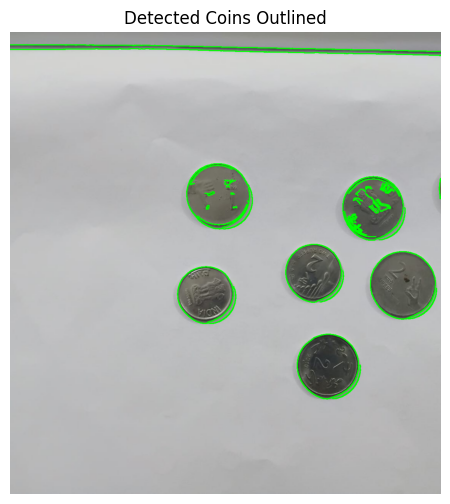

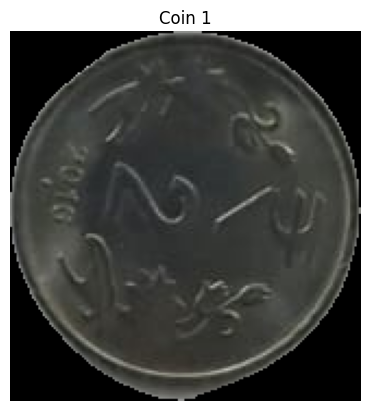

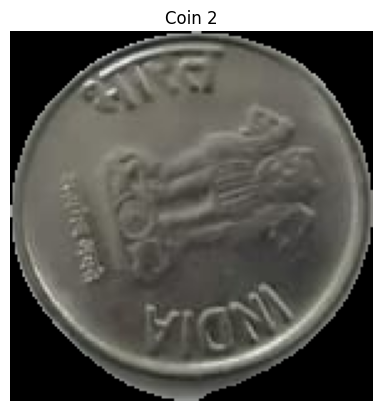

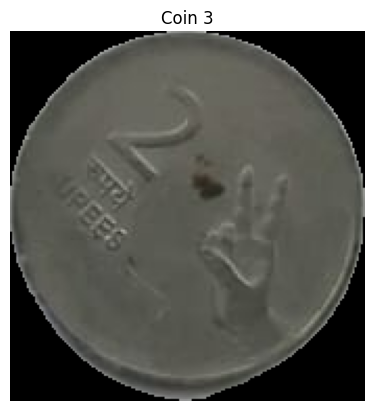

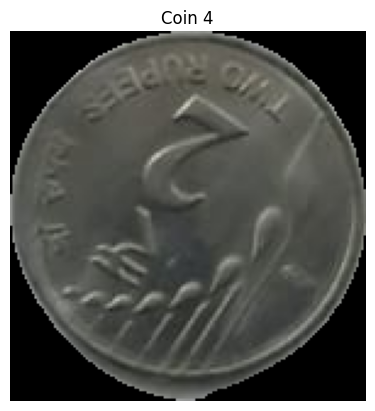

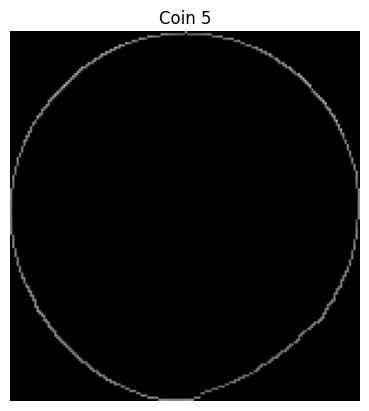

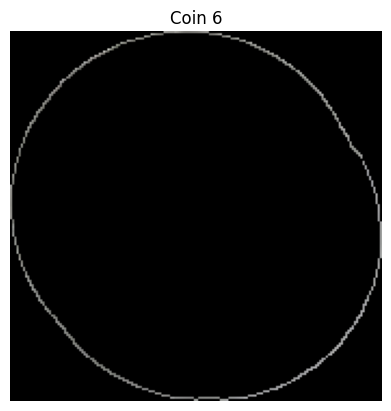

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/coins2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

edges = cv2.Canny(blurred, threshold1=30, threshold2=80)

contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

detected_coins = img.copy()
cv2.drawContours(detected_coins, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(detected_coins, cv2.COLOR_BGR2RGB))
plt.title("Detected Coins Outlined")
plt.axis("off")
plt.show()

coin_images = []

min_area = 90

for i, contour in enumerate(contours):
    if cv2.contourArea(contour) < min_area:
        continue

    mask = np.zeros(gray.shape, dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)

    coin_masked = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(contour)
    coin = coin_masked[y:y+h, x:x+w]

    coin_images.append(coin)

for idx, coin in enumerate(coin_images):
    plt.figure()
    plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
    plt.title(f"Coin {idx + 1}")
    plt.axis("off")
plt.show()


In [ ]:
def count_coins(contours):
    # Optionally, filter out small contours based on area
    min_area = 90  # adjust this threshold as needed
    coin_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    return len(coin_contours)

# Count coins based on contours from edge detection
num_coins = count_coins(contours)
print("Total number of coins detected:", num_coins)


Total number of coins detected: 6
